<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic15/5_PyTorch_Autograd_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

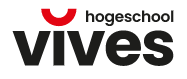<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



**PYTORCH TUTORIAL**

Deze tutorial is overgenomen van de PyTorch website:

https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html

# Automatic Differentiation with ``torch.autograd``

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine
called ``torch.autograd``. It supports automatic computation of gradient for any
computational graph.

Consider the simplest one-layer neural network, with input ``x``,
parameters ``w`` and ``b``, and some loss function. It can be defined in
PyTorch in the following manner:


In [1]:
%matplotlib inline

In [2]:
import torch

In [4]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b  # in NumPy: dot(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)  # _with_logits as z does not contain probabilities
loss

tensor(1.3696, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Tensors, Functions and Computational graph

This code defines the following **computational graph**:

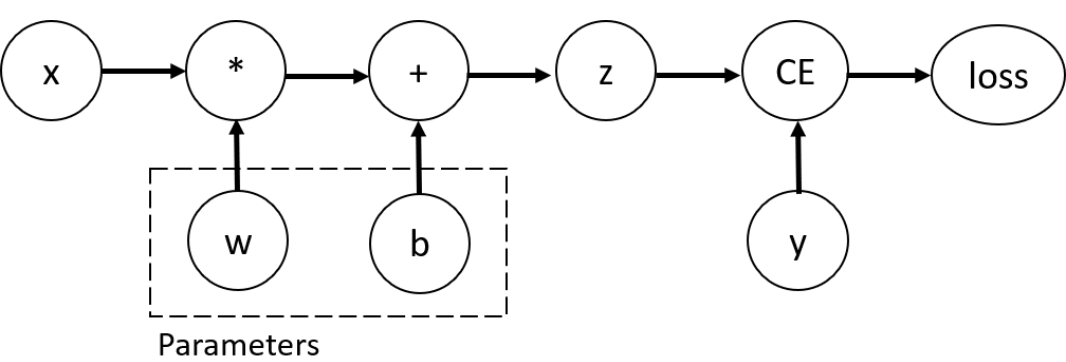

In this network, ``w`` and ``b`` are **parameters**, which we need to
optimize. Thus, we need to be able to compute the gradients of the loss
function with respect to those variables. In order to do that, we set
the ``requires_grad`` property of those tensors.

**Note**

You can set the value of `requires_grad` when creating a
          tensor, or later by using `x.requires_grad_(True)` method.



A function that we apply to tensors to construct the computational graph is
in fact an object of class ``Function``. This object knows how to
compute the function in the *forward* direction, and also how to compute
its derivative during the *backward propagation* step. A reference to
the backward propagation function is stored in ``grad_fn`` property of a
tensor. You can find more information of ``Function`` [in the
documentation](https://pytorch.org/docs/stable/autograd.html#function)_.




In [5]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7a733ab76050>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7a733ab75f90>


## Computing Gradients

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to the parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of
``x`` and ``y``. To compute those derivatives, we call
``loss.backward()``, and then retrieve the values from ``w.grad`` and
``b.grad``:




In [6]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2741, 0.0452, 0.2977],
        [0.2741, 0.0452, 0.2977],
        [0.2741, 0.0452, 0.2977],
        [0.2741, 0.0452, 0.2977],
        [0.2741, 0.0452, 0.2977]])
tensor([0.2741, 0.0452, 0.2977])


**Notes**

- We can only obtain the ``grad`` properties for the leaf
    nodes of the computational graph, which have ``requires_grad`` property
    set to ``True``. For all other nodes in our graph, gradients will not be
    available.
- We can only perform gradient calculations using
    ``backward`` once on a given graph, for performance reasons. If we need
    to do several ``backward`` calls on the same graph, we need to pass
    ``retain_graph=True`` to the ``backward`` call.
- We were calling ``backward()`` without parameters. This is essentially equivalent to calling ``backward(torch.tensor(1.0))``, which is a useful way to compute the gradients in case of a scalar-valued function, such as loss during neural network training.



## Disabling Gradient Tracking

By default, all tensors with ``requires_grad=True`` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
``torch.no_grad()`` block:




In [7]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the ``detach()`` method
on the tensor:




In [8]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


There are reasons you might want to disable gradient tracking:
  - To mark some parameters in your neural network as **frozen parameters**. This is
    a very common scenario for
    [finetuning a pretrained network](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)_
  - To **speed up computations** when you are only doing the forward pass, because computations on tensors that do
    not track gradients would be more efficient.



## More on Computational Graphs
Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)_
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using **the chain rule**.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when ``.backward()`` is called on the DAG root. ``autograd`` then:

- computes the gradients from each ``.grad_fn``,
- accumulates them in the respective tensor’s ``.grad`` attribute
- using the chain rule, propagates all the way to the leaf tensors.

**Note: DAGs are dynamic in PyTorch**

An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>



--------------




### Further Reading
- [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html)



---